# 15_SSB_data_eda (Exploratory Data Analysis)

## Population and crime rates on the municipality level in Norway.

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import shapely
from pyproj import Transformer
import geopandas as gpd
import openpyxl

pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [27]:
# import data - data_clean
data = gpd.read_file('../data/SSB_norway_12.03.24/cleaned/borders_population_crime_clean.geojson')
print("original crs: ", data.crs)
data = data.set_crs("EPSG:32633", allow_override=True) # UTM 33N
print("new crs: ", data.crs)
data.head(2)

original crs:  EPSG:4326
new crs:  EPSG:32633


,kommuneID,kommuneNavn,befolkning,befolkning_pr_km2,anmeldteLovbrudd(avg),geometry
0,301,Oslo,717710,1683,59973,"MULTIPOLYGON (((260102.430 6645441.707, 260388..."
1,1101,Eigersund,15221,39,649,"MULTIPOLYGON (((-21958.167 6520966.524, -21980..."


In [32]:
# rename to english column names
# rename columns from: ['kommuneID', 'kommuneNavn', 'befolkning', 'befolkning_pr_km2', 'anmeldteLovbrudd(avg)', 'geometry']
# to: ['municipalityID', 'municipalityName', 'population', 'populationPerKm2', 'reportedOffences', 'geometry']
data = data.rename(columns={'kommuneID': 'municipalityID', 'kommuneNavn': 'municipalityName', 'befolkning': 'population', 'befolkning_pr_km2': 'populationPerKm2', 'anmeldteLovbrudd(avg)': 'reportedOffences'})

# sort by population, descending
data = data.sort_values(by='population', ascending=False)
data.head(8)

,municipalityID,municipalityName,population,populationPerKm2,reportedOffences,geometry
0,301,Oslo,717710,1683,59973,"MULTIPOLYGON (((260102.430 6645441.707, 260388..."
237,4601,Bergen,291940,656,16178,"MULTIPOLYGON (((-38244.020 6735474.349, -38306..."
280,5001,Trondheim - Tråante,214565,432,12612,"MULTIPOLYGON (((260249.217 7048364.166, 259613..."
2,1103,Stavanger,149048,582,8570,"MULTIPOLYGON (((-29201.111 6570959.101, -28783..."
104,3201,Bærum,130921,694,5663,"MULTIPOLYGON (((243924.060 6658193.500, 243901..."
215,4204,Kristiansand,116986,192,8194,"MULTIPOLYGON (((65399.512 6480946.298, 65474.8..."
125,3301,Drammen,104487,342,5713,"MULTIPOLYGON (((229575.126 6635746.779, 229567..."
105,3203,Asker,98815,271,3621,"MULTIPOLYGON (((248622.970 6646257.340, 248544..."


In [29]:
# make a data subset that excludes the municipalities with highest population numbers
data_lowPop = data[data['population'] < 150000]

Now, the data has the right structure for the analysis.   
Since there is a large variation in population numbers among the municipalities, we will start by looking at the population distribution.  

In [30]:
# population distribution
print("population median: ", data['population'].median())
data['population'].describe()

population median:  5322.0


count      357.000
mean     15546.787
std      45848.708
min        215.000
25%       2237.000
50%       5322.000
75%      13593.000
max     717710.000
Name: population, dtype: float64

Here we see population is max in Oslo with 717710, while minimum of 215 in the municipality of Utsira.   
Mean population is 15546, while median is 5322, which indicates that the distribution is skewed to the right.

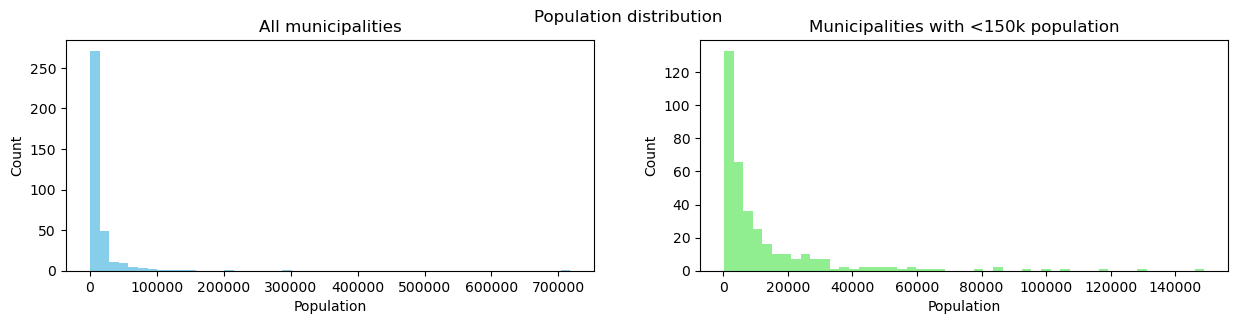

In [36]:
# Subplots that plot the population distribution for the entire dataset and the subset
fig, ax = plt.subplots(1, 2, figsize=(15, 3))
fig.suptitle('Population distribution')
ax[0].hist(data['population'], bins=50, color='skyblue')
ax[0].set_title('All municipalities')
ax[0].set_xlabel('Population')
ax[0].set_ylabel('Count')
ax[1].hist(data_lowPop['population'], bins=50, color='lightgreen')
ax[1].set_title('Municipalities with <150k population')
ax[1].set_xlabel('Population')
ax[1].set_ylabel('Count')
plt.show()

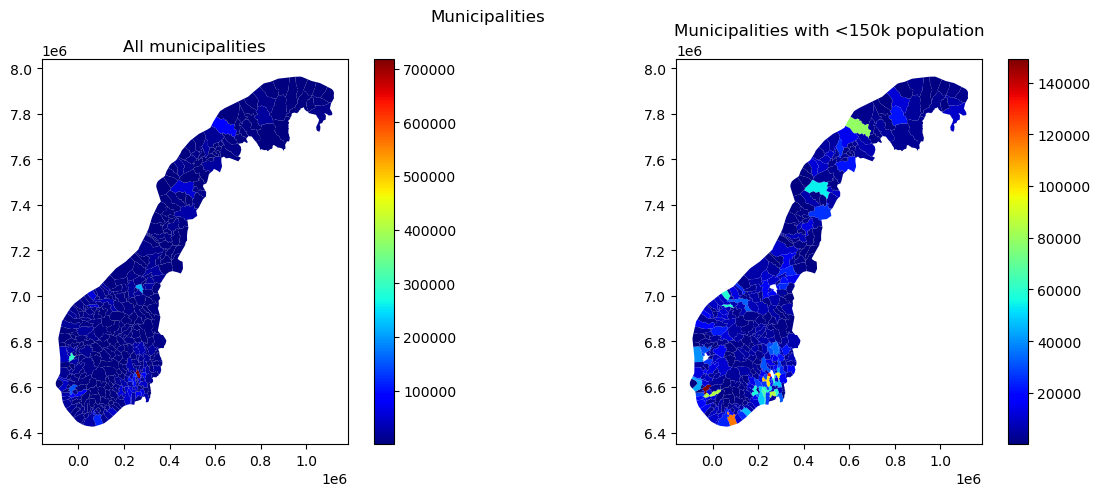

In [45]:
# map subplots of the entire dataset and the subset
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Municipalities')
data.plot(column='population', cmap='jet', ax=ax[0], legend=True)
ax[0].set_title('All municipalities')
data_lowPop.plot(column='population', cmap='jet', ax=ax[1], legend=True)
ax[1].set_title('Municipalities with <150k population')
plt.show()

Next, we will look at the crime rates. We will start by looking at the distribution of the crime rates.

In [46]:
# Crime rates distribution
print("reportedOffences median: ", data['reportedOffences'].median())
data['reportedOffences'].describe()

reportedOffences median:  183.0


count     357.000
mean      797.378
std      3476.592
min        -1.000
25%        71.000
50%       183.000
75%       558.000
max     59973.000
Name: reportedOffences, dtype: float64

Here we see reportedOffences is max in Oslo with 59973, while minimum of 7 in the municipality of Kvitsøy. If we ignore Utsira, Gildeskål and Haram which all have value -1, indicating missing data.   
Mean reportedOffences is 797, while median is 183, which indicates that the distribution also is skewed to the right.

Next, we will look at the relationship between the population and the crime rates. We start by comparing the distributions of the two variables.

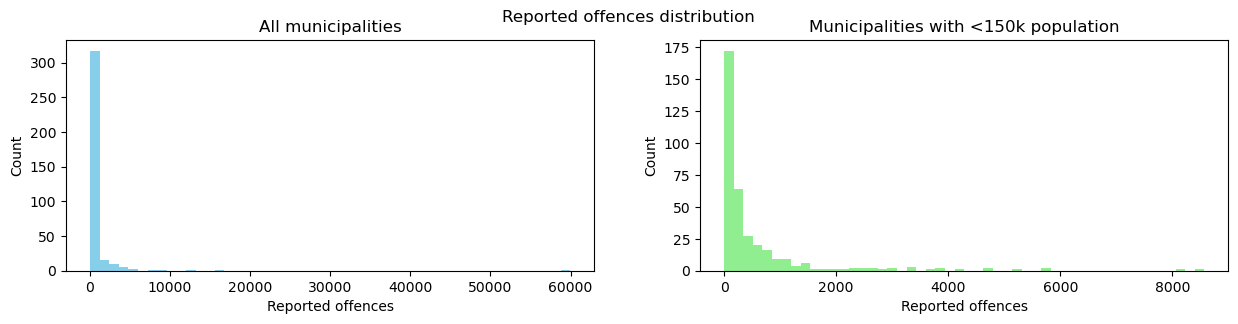

In [59]:
# compare distributions of population and reportedOffences
fig, ax = plt.subplots(1, 2, figsize=(15, 3))
fig.suptitle('Reported offences distribution')
ax[0].hist(data['reportedOffences'], bins=50, color='skyblue')
ax[0].set_title('All municipalities')
ax[0].set_xlabel('Reported offences')
ax[0].set_ylabel('Count')
ax[1].hist(data_lowPop['reportedOffences'], bins=50, color='lightgreen')
ax[1].set_title('Municipalities with <150k population')
ax[1].set_xlabel('Reported offences')
ax[1].set_ylabel('Count')
plt.show()

As expected, both distributions are strongly skewed to the right. Next, we will look at the relationship between the two variables. We will start by looking at the correlation between the two variables. 

Correlation between population and crime rates:                    population  reportedOffences
population             1.000             0.979
reportedOffences       0.979             1.000


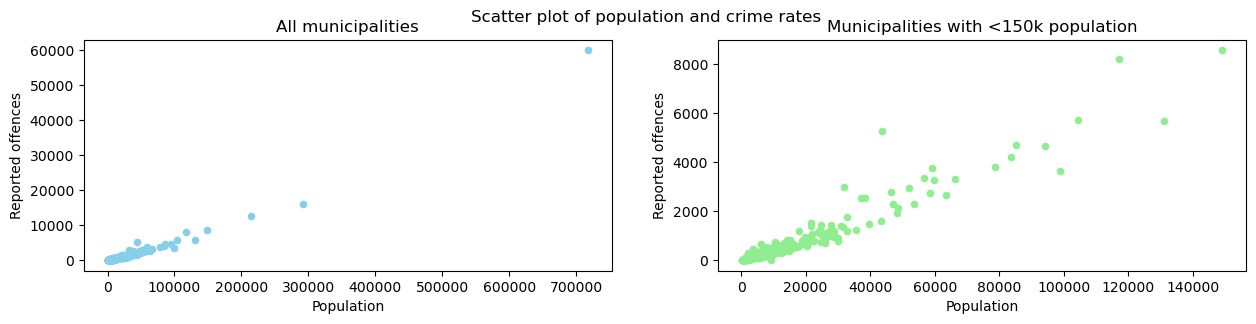

In [79]:
# Correlation between population and crime rates
print("Correlation between population and crime rates: ", data[['population', 'reportedOffences']].corr())
# data[['population', 'reportedOffences']].corr()

# Scatter plot of population and crime rates
fig, ax = plt.subplots(1, 2, figsize=(15, 3))
fig.suptitle('Scatter plot of population and crime rates')
data.plot.scatter(x='population', y='reportedOffences', ax=ax[0], color='skyblue')
ax[0].set_title('All municipalities')
ax[0].set_xlabel('Population')
ax[0].set_ylabel('Reported offences')
data_lowPop.plot.scatter(x='population', y='reportedOffences', ax=ax[1], color='lightgreen')
ax[1].set_title('Municipalities with <150k population')
ax[1].set_xlabel('Population')
ax[1].set_ylabel('Reported offences')
plt.show()

model slope:  [0.07422583]
model intercept:  -356.59502879672095
model R-squared:  0.9582013445009613
model_lowPop slope:  [0.05248371]
model_lowPop intercept:  -87.97427318612483
model_lowPop R-squared:  0.9234189923322756


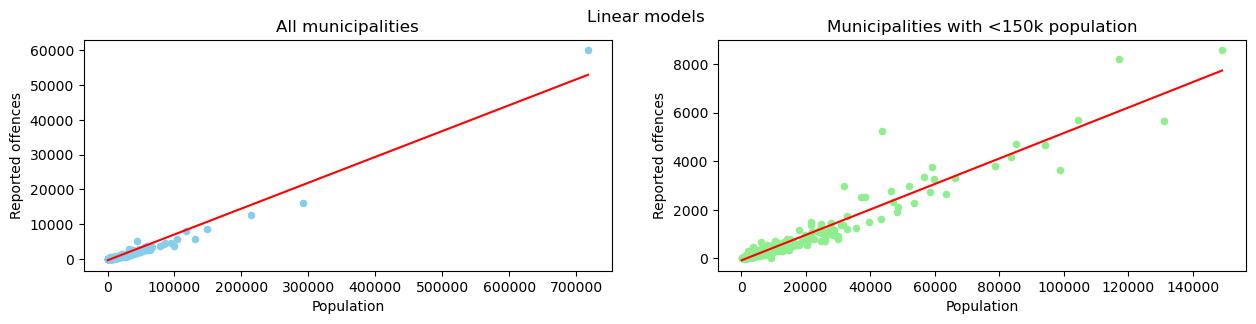

In [74]:
# Next we try to fit both a linear and non-linear model to the data

# fit a linear model to the full data
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(data[['population']], data['reportedOffences'])
print("model slope: ", model.coef_)
print("model intercept: ", model.intercept_)
print("model R-squared: ", model.score(data[['population']], data['reportedOffences']))

# fit a linear model to the subset data (excluding the municipalities with highest population numbers)
model_lowPop = LinearRegression()
model_lowPop.fit(data_lowPop[['population']], data_lowPop['reportedOffences'])
print("model_lowPop slope: ", model_lowPop.coef_)
print("model_lowPop intercept: ", model_lowPop.intercept_)
print("model_lowPop R-squared: ", model_lowPop.score(data_lowPop[['population']], data_lowPop['reportedOffences']))

# plot the linear models
fig, ax = plt.subplots(1, 2, figsize=(15, 3))
fig.suptitle('Linear models')
data.plot.scatter(x='population', y='reportedOffences', ax=ax[0], color='skyblue')
ax[0].set_title('All municipalities')
ax[0].set_xlabel('Population')
ax[0].set_ylabel('Reported offences')
ax[0].plot(data['population'], model.predict(data[['population']]), color='red')
data_lowPop.plot.scatter(x='population', y='reportedOffences', ax=ax[1], color='lightgreen')
ax[1].set_title('Municipalities with <150k population')
ax[1].set_xlabel('Population')
ax[1].set_ylabel('Reported offences')
ax[1].plot(data_lowPop['population'], model_lowPop.predict(data_lowPop[['population']]), color='red')
plt.show()

model_poly R-squared:  0.9922934250183655
model_lowPop_poly R-squared:  0.9259699940498027


c:\ProgramData\miniconda3\envs\MCLP_env\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
c:\ProgramData\miniconda3\envs\MCLP_env\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


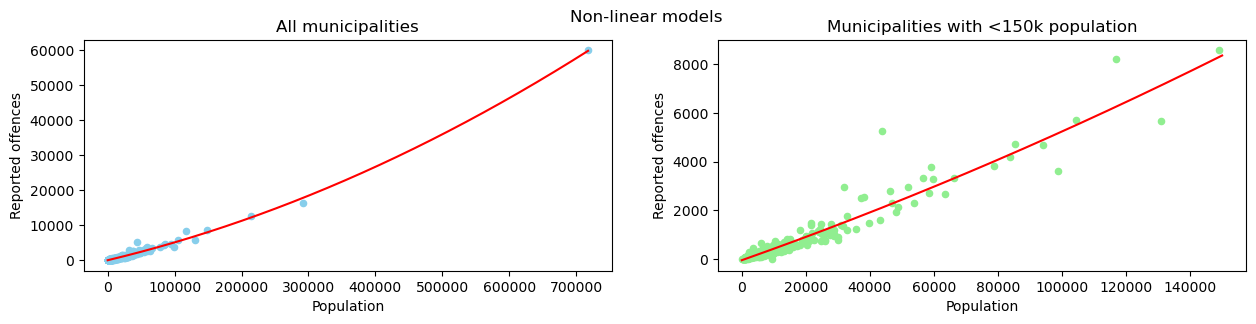

In [80]:
# Next, we fit a non-linear model to both the full data and subset - polynomial regression model of 2nd degree
# fit a non-linear model to the full data
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
model_poly = make_pipeline(PolynomialFeatures(2), LinearRegression())
model_poly.fit(data[['population']], data['reportedOffences'])
print("model_poly R-squared: ", model_poly.score(data[['population']], data['reportedOffences']))

# fit a non-linear model to the subset data (excluding the municipalities with highest population numbers)
model_lowPop_poly = make_pipeline(PolynomialFeatures(2), LinearRegression())
model_lowPop_poly.fit(data_lowPop[['population']], data_lowPop['reportedOffences'])
print("model_lowPop_poly R-squared: ", model_lowPop_poly.score(data_lowPop[['population']], data_lowPop['reportedOffences']))

# plot the non-linear models
fig, ax = plt.subplots(1, 2, figsize=(15, 3))
fig.suptitle('Non-linear models')
data.plot.scatter(x='population', y='reportedOffences', ax=ax[0], color='skyblue')
ax[0].set_title('All municipalities')
ax[0].set_xlabel('Population')
ax[0].set_ylabel('Reported offences')
x = np.linspace(0, 717710, 1000)
ax[0].plot(x, model_poly.predict(x.reshape(-1, 1)), color='red')
data_lowPop.plot.scatter(x='population', y='reportedOffences', ax=ax[1], color='lightgreen')
ax[1].set_title('Municipalities with <150k population')
ax[1].set_xlabel('Population')
ax[1].set_ylabel('Reported offences')
x2 = np.linspace(0, 150000, 1000)
ax[1].plot(x2, model_lowPop_poly.predict(x2.reshape(-1, 1)), color='red')
plt.show()

Results (on municipality level):
- Correlation between population and reportedOffences: 0.979
- Linear model, R-squared:  0.9582
- 2nd degree polynomial model, R-squared:  0.9922

The correlation between the population and the crime rates is 0.979, which indicates a strong positive relationship.   
Moreover, the linear model explains 95.82% of the variation in the crime rates, while the 2nd degree polynomial model explains 99.22%. This indicates that the relationship between the population and the crime rates is non-linear. It is also visible in the plots that the 2nd degree polynomial model fits the data better than the linear model.